## Final Assessment: N-body simulation of Argon atoms in a box

### Task 1: Producing the N-body code

In [58]:
#importing modules
import numpy as np
import matplotlib.pyplot as plt

In [59]:
#setting up the system
n = 27 #number of particles, has to be a cube number as I want an equal number of particles in each dimension
m = 6.6341343e-26 #mass of an argon atom

arraySize = (n,3) # setting up the shape of a 3D array

#Creating the position array
 
partPos = np.zeros(arraySize)

In [60]:
#Defining the number of particles along each dimension
nDim = 3
"""
Defining the range of random separation in each axis, these act as a randomising factor within the lattice,
so you can experiment with different configurations with ease. These are small numbers so they don't trigger a separation
distance in the order of sigma.
"""

xRange = (0.00000005, 0.00000006)
yRange = (0.00000005, 0.00000006)
zRange = (0.00000005, 0.00000006)

#Generation of the lattice using numpy's meshgrid function
x, y, z = np.meshgrid(
    np.linspace(0,0.000001, nDim),
    np.linspace(0,0.000001, nDim),
    np.linspace(0,0.000001, nDim),
    indexing='ij'
)
#stacking arrays and converting to single dimension
partPos = np.column_stack((x.flatten(), y.flatten(), z.flatten()))

#Adding a random displacement to each particle using the ranges previously described
randomSep = np.random.uniform(
    low=[xRange[0], yRange[0], zRange[0]],
    high=[xRange[1], yRange[1], zRange[1]],
    size=(nDim**3, 3)
)

#converting data type
partPos = partPos.astype(np.float64)

#adding the random separation to the default lattice
partPos += randomSep



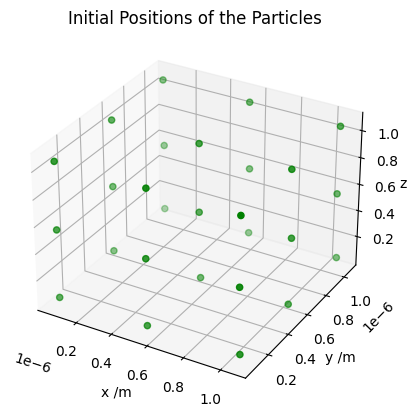

In [61]:
#Visualising the lattice - an example of testing my code throughout to make sure it's doing what I want
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(partPos[:, 0], partPos[:, 1], partPos[:, 2], c='g', marker='o')
ax.set_xlabel('x /m')
ax.set_ylabel('y /m')
ax.set_zlabel('z /m')
ax.set_title('Initial Positions of the Particles')
plt.show()

In [62]:
"""
Creating the velocity array, setting all the velocity values initially at rest so we can observe only the effects of the
#Lennard Jones potential
"""
partVel = np.zeros(arraySize)

In [63]:
#creating a 3d array for the acceleration of particles
#again values initially set to zero, these will be defined later when computing the vel verlet method
partAcc = np.zeros(arraySize)


In [64]:
#defining constants
kB = 1.38*10**-23
epsilon = 125.7 * kB 
sigma = 0.3345*10**-9



def computePotential(partPos):
    """Function that computes the potential and returns the differences in positions of the particles"""
    #using array operations for more efficient code
    xDiff = partPos[:, 0, np.newaxis] - partPos[:, 0] #computing the difference in x pos 
    yDiff = partPos[:, 1, np.newaxis] - partPos[:, 1] #computing the difference in x pos 
    zDiff = partPos[:, 2, np.newaxis] - partPos[:, 2] #computing the difference in x pos 

    #nDiff returns a (n,n) shape array with all the differences between the particles in their respective components
    
    #computing the magnitude of the distance between particles in 3D using pythoagoras
    rDiff = np.sqrt(xDiff**2 + yDiff**2 + zDiff**2) 

    #computing the potential array using the Lennard Jones potential 
    potentialArray = 4*epsilon*((sigma/rDiff)**12 - (sigma/rDiff)**6)

    np.fill_diagonal(potentialArray,0) #setting the self interaction terms to zero

    #computing the total potential of the system 
    totalPotential = np.sum(potentialArray)

    return potentialArray, totalPotential, rDiff, xDiff, yDiff, zDiff


# Creating a function to compute the forces on each individual particle
def computeForces(rDiff, xDiff, yDiff , zDiff):
    """
    The analytical solution of the lennard jones is obtainable with some
    trivial differentiation. 
    """
    # compute the force from c
    F = -(48*epsilon*(sigma**12/rDiff**13)-24*epsilon*(sigma**6/rDiff**7))

    #setting self-interaction terms to zero
    np.fill_diagonal(F,0) 
    #deleting nan terms
    F = np.nan_to_num(F)
    
    #computation of the unit vectors
    
    xUnit = xDiff/rDiff
    yUnit = yDiff/rDiff
    zUnit = zDiff/rDiff
    
    #deleting nan values
    xUnit = np.nan_to_num(xUnit)
    yUnit = np.nan_to_num(yUnit)
    zUnit = np.nan_to_num(zUnit)


    #compute the forces in each component
    fx = F*xUnit
    fy = F*yUnit
    fz = F*zUnit

    
    return F, fx, fy, fz

def acceleration(m, fx, fy, fz):
    #computing the components of acceleration
    ax = fx/m
    ay = fy/m
    az = fz/m
    
    #Summing accelration to find the total acceleration on a particle
    axSum = np.sum(ax, axis=1)
    axSumArray = np.array(axSum)

    aySum = np.sum(ay, axis=1)
    aySumArray = np.array(aySum)

    azSum = np.sum(az, axis=1)
    azSumArray = np.array(azSum)

    return axSum, aySum, azSum
def velVerlet(partPos, partVel, fx,fy,fz,dt):
    
    #obtainin accelerations
    ax, ay, az = acceleration(m, fx,fy,fz)

    #updating velocity
    partVel[:,0] += 0.5*ax*dt
    partVel[:,1] += 0.5*ay*dt
    partVel[:,2] += 0.5*az*dt
    
    # updating position, could have used an array operation but I wanted to do a more manual method for some testing
    for i in range(n):

        partPos[i][0] += partVel[i][0]*dt
        partPos[i][1] += partVel[i][1]*dt
        partPos[i][2] += partVel[i][2]*dt
        

    # update the new forces based on the new position
    potentialArray, totalPotential, rDiff, xDiff, yDiff, zDiff = computePotential(partPos)
    F, fx, fy, fz = computeForces(rDiff, xDiff, yDiff , zDiff)

    # recompute acceleration
    
    ax, ay, az = acceleration(m, fx,fy,fz)

    #finally update velocity for the second half of the time step
    partVel[:,0] += 0.5*ax*dt
    partVel[:,1] += 0.5*ay*dt
    partVel[:,2] += 0.5*az*dt
    
    
    return partAcc, partVel, partPos

def calcKinetic(n, partVel):
    #Calculating total ke for a given time step
    kineticStep = 0
    #no array operation for testing purposes
    for v in range(n):
        ke = 0.5*m*np.sum(partVel[v]**2)
        kineticStep+=ke
    return kineticStep
def calcTemp(kineticStep,n, kB):
    #calcualting temperature for each time step
    T = (kineticStep*(2/3))/kB*n
    return T




In [65]:

n = 27 # redefining number of particles, for some reason the code likes it
dt = 0.1 # defining timestep

#grabbbing some intial  values
potentialArray, totalPotential, rDiff, xDiff, yDiff, zDiff = computePotential(partPos)
F, fx, fy, fz = computeForces(rDiff, xDiff, yDiff , zDiff)
ax, ay, az = acceleration(m, fx,fy,fz)

t = 0 #setting up a running value for time
time = [] # time list to be appended to each time step
steps = 1000 #number of steps
posArray = np.empty((steps, n, 3)) #posArray to carry the position values at each time step, a mother of an array!
# lists for the quantities i want to investigate
kineticEng = []
temp = []
pressure = []
#the main for loop to implement the vel verlet method
for i in range(steps):
    #appending to lists
    kineticStep = calcKinetic(n, partVel)
    kineticEng.append(kineticStep)
    temp.append(calcTemp(kineticStep,n, kB))
    time.append(t)

    partAcc, partVel, partPos = velVerlet(partPos, partVel, fx,fy,fz,dt)
    posArray[i] = partPos
    t+=dt #updating time


C:\Users\sarah\AppData\Local\Temp\ipykernel_6932\3421843712.py:21: RuntimeWarning: divide by zero encountered in divide
  potentialArray = 4*epsilon*((sigma/rDiff)**12 - (sigma/rDiff)**6)
C:\Users\sarah\AppData\Local\Temp\ipykernel_6932\3421843712.py:21: RuntimeWarning: invalid value encountered in subtract
  potentialArray = 4*epsilon*((sigma/rDiff)**12 - (sigma/rDiff)**6)
C:\Users\sarah\AppData\Local\Temp\ipykernel_6932\3421843712.py:38: RuntimeWarning: divide by zero encountered in divide
  F = -(48*epsilon*(sigma**12/rDiff**13)-24*epsilon*(sigma**6/rDiff**7))
C:\Users\sarah\AppData\Local\Temp\ipykernel_6932\3421843712.py:38: RuntimeWarning: invalid value encountered in subtract
  F = -(48*epsilon*(sigma**12/rDiff**13)-24*epsilon*(sigma**6/rDiff**7))
C:\Users\sarah\AppData\Local\Temp\ipykernel_6932\3421843712.py:47: RuntimeWarning: invalid value encountered in divide
  xUnit = xDiff/rDiff
C:\Users\sarah\AppData\Local\Temp\ipykernel_6932\3421843712.py:48: RuntimeWarning: invalid valu

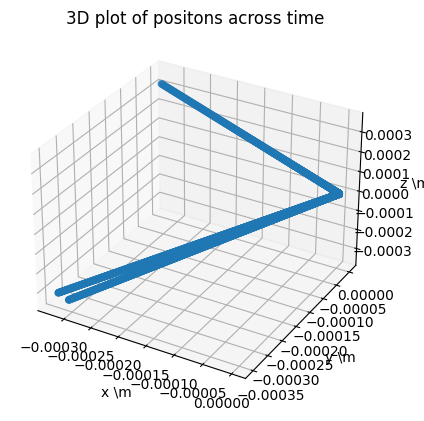

In [66]:
from mpl_toolkits.mplot3d import Axes3D
#3D plot of the positions of the particles, mainly for testing purposes
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = posArray[:, 0]  #Extracting x values
y = posArray[:, 1]  #Extracting x values
z = posArray[:, 2]  #Extracting x values

#scatter graph
ax.scatter(x, y, z)

ax.set_xlabel('x \m')
ax.set_ylabel('y \m')
ax.set_zlabel('z \m')
ax.set_title('3D plot of positons across time')
plt.show()

MovieWriter ffmpeg unavailable; using Pillow instead.


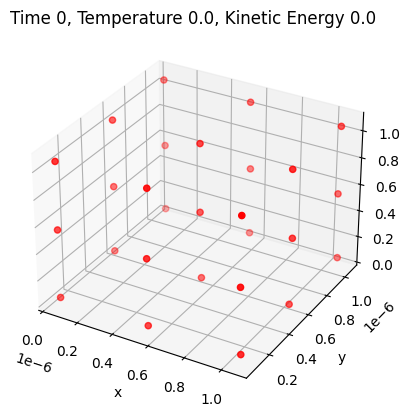

In [72]:
'''This cell animates the simulation, feel free to uncomment and have a try yourself, however it can take a while to run'''
from matplotlib.animation import FuncAnimation
#ANIMATION OF THE SIMUALTION
# Create the figure and axis for the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

#defining the function that will be called for each frame of the animation of simuation 
def update(frame):
    ax.clear()
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    ax.set_title(f'Time {time[frame]}, Temperature {temp[frame]}, Kinetic Energy {kineticEng[frame]} ')
    ax.scatter(posArray[frame,:,0], posArray[frame,:,1], posArray[frame,:,2], c='r', marker='o')

#creating the animation object
anim = FuncAnimation(fig, update, frames=steps, interval=50)

#saving the animation
anim.save('noboundaryNEWPOS.gif')




Time 99.8999999999986, Temperature 1.0962184687000354e-10, Kinetic Energy 8.404341593366937e-35


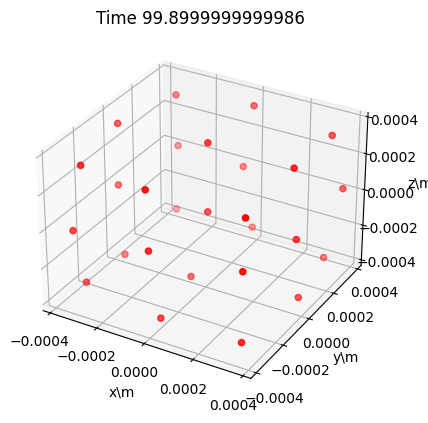

In [74]:
#Creating a plot where I can observe a single frame
fig = plt.figure()
frame = 999
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('x\m')
ax.set_ylabel('y\m')
ax.set_zlabel('z\m')
ax.set_title(f'Time {time[frame]}')
ax.scatter(posArray[frame,:,0], posArray[frame,:,1], posArray[frame,:,2], c='r', marker='o')
print(f'Time {time[frame]}, Temperature {temp[frame]}, Kinetic Energy {kineticEng[frame]}')
plt.savefig(f'part{n}frame{frame}.png')

Text(0.5, 1.0, 'Temperature vs Time')

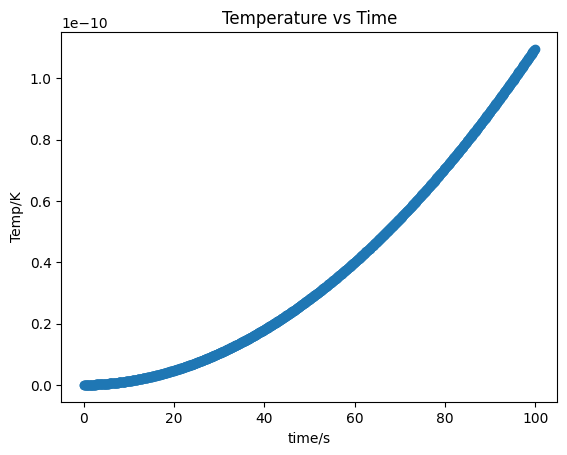

In [69]:
#Temperature vs time plot
fig,ax = plt.subplots()
ax.scatter(time, temp)
ax.set_xlabel('time/s')
ax.set_ylabel('Temp/K')
ax.set_title('Temperature vs Time')

Text(0.5, 1.0, 'Kinetic Energy vs Time')

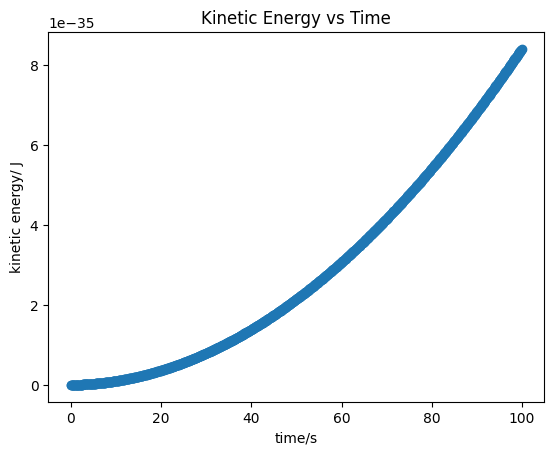

In [70]:
#Kinetic energy vs time plot
fig,ax = plt.subplots()
ax.scatter(time, kineticEng)
ax.set_xlabel('time/s')
ax.set_ylabel('kinetic energy/ J')
ax.set_title('Kinetic Energy vs Time')